In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras.utils import to_categorical


In [2]:
# Load MNIST dataset
(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = tf.keras.datasets.mnist.load_data()
mnist_x_train, mnist_x_test = mnist_x_train / 255.0, mnist_x_test / 255.0

# Load CIFAR-10 dataset
(cifar10_x_train, cifar10_y_train), (cifar10_x_test, cifar10_y_test) = tf.keras.datasets.cifar10.load_data()
cifar10_x_train, cifar10_x_test = cifar10_x_train / 255.0, cifar10_x_test / 255.0

# Splitting MNIST dataset into train, validation, and test sets
mnist_x_train, mnist_x_val, mnist_y_train, mnist_y_val = train_test_split(
    mnist_x_train, mnist_y_train, train_size=0.8, test_size=0.2, random_state=42
)
mnist_x_test, mnist_y_test = mnist_x_test[:1000], mnist_y_test[:1000]  # Limiting test set size

# Splitting CIFAR-10 dataset into train, validation, and test sets
cifar10_x_train, cifar10_x_val, cifar10_y_train, cifar10_y_val = train_test_split(
    cifar10_x_train, cifar10_y_train, train_size=0.8, test_size=0.2, random_state=42
)
cifar10_x_test, cifar10_y_test = cifar10_x_test[:1000], cifar10_y_test[:1000]  # Limiting test set size

170498071/170498071 [==============================] - 2s 0us/step


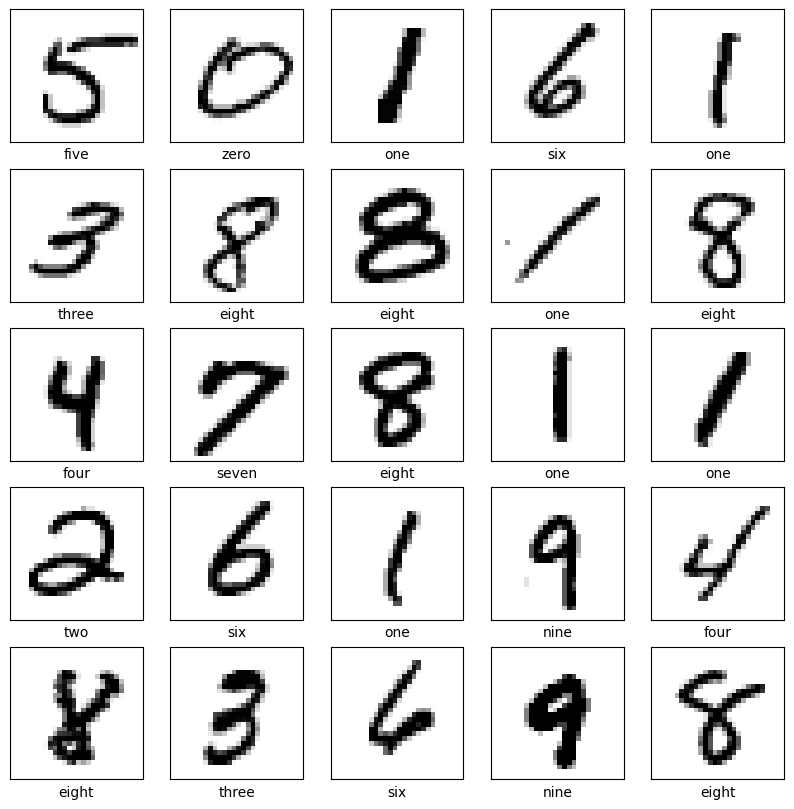

In [3]:
# Class names for plotting
class_names_mnist = ['zero', 'one', 'two', 'three', 'four',
                     'five', 'six', 'seven', 'eight', 'nine']
# Plot MNIST samples
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(mnist_x_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names_mnist[mnist_y_train[i]])
plt.show()


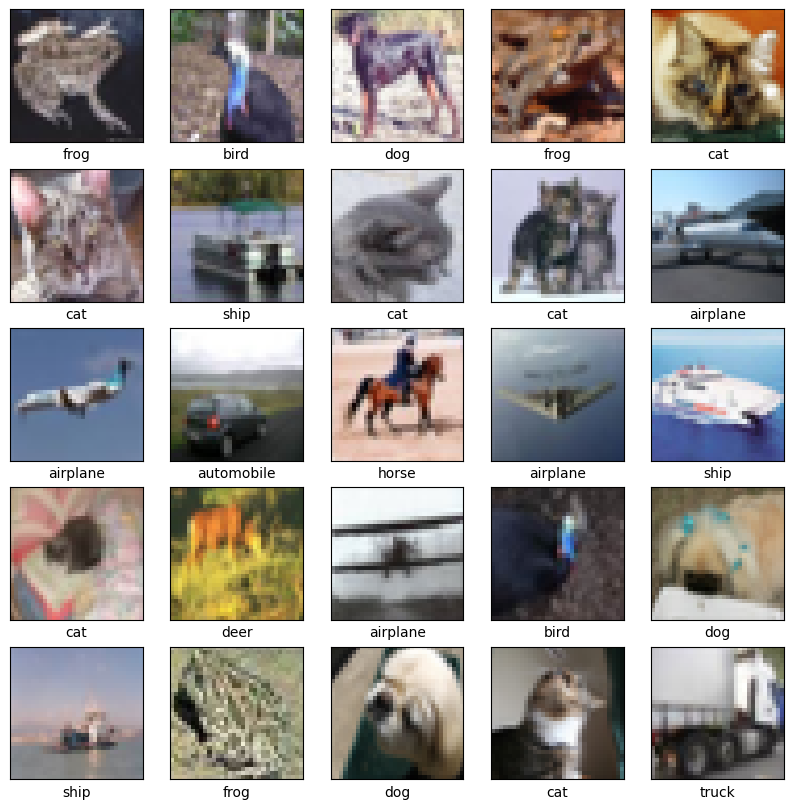

In [4]:
class_names_cifar10 = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                       'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(cifar10_x_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names_cifar10[cifar10_y_train[i][0]])
plt.show()

In [5]:
# Create an instance of the ResNet50 model
ResNet_model = keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Print the model summary
ResNet_model.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                      

In [6]:
# Define the input shapes for MNIST and CIFAR-10
input_shape_mnist = (28, 28, 1)
input_shape_cifar10 = (32, 32, 3)

# Create models for MNIST and CIFAR-10 using ResNet50 as a feature extractor
mnist_model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

mnist_model.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])
cifar10_model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

cifar10_model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

# Set the input shapes for the models
mnist_model.build((None,) + input_shape_mnist)
cifar10_model.build((None,) + input_shape_cifar10)

# Compile the models
mnist_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cifar10_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [7]:
# Create an instance of the ResNet50 model
ResNet_model = keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Set all layers in the ResNet50 model to non-trainable
for layer in ResNet_model.layers:
    layer.trainable = False

# Define the new model using the functional API
inputs = keras.Input(shape=(224, 224, 3))
x = ResNet_model(inputs, training=False)  # Use the ResNet50 model as a layer
x = GlobalAveragePooling2D()(x)
x = Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs=inputs, outputs=x)

model.summary()

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_4 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 23589761 (89.99 MB)
Trainable params: 2049 (8.00 KB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [8]:
mnist_model.fit(mnist_x_train, mnist_y_train, epochs=10)

Epoch 1/10
1500/1500 [==============================] - 8s 5ms/step - loss: 0.2877 - accuracy: 0.9179
Epoch 2/10
1500/1500 [==============================] - 5s 4ms/step - loss: 0.1307 - accuracy: 0.9617
Epoch 3/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0888 - accuracy: 0.9736
Epoch 4/10
1500/1500 [==============================] - 5s 4ms/step - loss: 0.0656 - accuracy: 0.9804
Epoch 5/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0499 - accuracy: 0.9847
Epoch 6/10
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0398 - accuracy: 0.9873
Epoch 7/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0319 - accuracy: 0.9902
Epoch 8/10
1500/1500 [==============================] - 5s 4ms/step - loss: 0.0256 - accuracy: 0.9930
Epoch 9/10
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0213 - accuracy: 0.9937
Epoch 10/10
1500/1500 [==============================] - 7s 4ms/step - loss: 0.017

In [9]:
cifar10_model.fit(cifar10_x_train, cifar10_y_train, epochs=10)

Epoch 1/10
1250/1250 [==============================] - 32s 25ms/step - loss: 1.4977 - accuracy: 0.4652
Epoch 2/10
1250/1250 [==============================] - 30s 24ms/step - loss: 1.2048 - accuracy: 0.5768
Epoch 3/10
1250/1250 [==============================] - 32s 25ms/step - loss: 1.0984 - accuracy: 0.6150
Epoch 4/10
1250/1250 [==============================] - 30s 24ms/step - loss: 1.0221 - accuracy: 0.6421
Epoch 5/10
1250/1250 [==============================] - 32s 25ms/step - loss: 0.9518 - accuracy: 0.6687
Epoch 6/10
1250/1250 [==============================] - 30s 24ms/step - loss: 0.8951 - accuracy: 0.6866
Epoch 7/10
1250/1250 [==============================] - 30s 24ms/step - loss: 0.8332 - accuracy: 0.7081
Epoch 8/10
1250/1250 [==============================] - 30s 24ms/step - loss: 0.7821 - accuracy: 0.7268
Epoch 9/10
1250/1250 [==============================] - 30s 24ms/step - loss: 0.7340 - accuracy: 0.7444
Epoch 10/10
1250/1250 [==============================] - 29s 24m

32/32 [==============================] - 0s 2ms/step


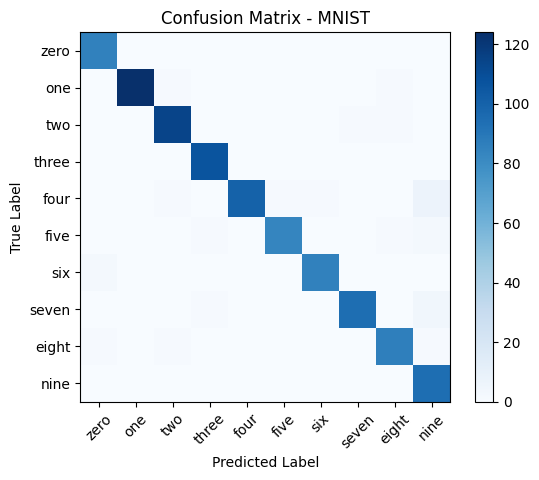

Precision - MNIST: 0.9724522961945705
Recall - MNIST: 0.9722798080992578
F1 score for MNIST: 0.9715797987734002


In [10]:
# Print confusion matrix and classification report for testing samples
def print_confusion_matrix_and_metrics(model, x_test, y_test, dataset_name, class_names):
    y_pred = np.argmax(model.predict(x_test), axis=1)
    cm = confusion_matrix(y_test, y_pred)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix - {dataset_name}")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

   # Print precision with zero_division parameter set
    precision = precision_score(y_test, y_pred, average='macro', zero_division=1.0)
    print(f"Precision - {dataset_name}: {precision}")

    # Print recall
    recall = recall_score(y_test, y_pred, average='macro')
    print(f"Recall - {dataset_name}: {recall}")
    # print f1 score
    f1 = f1_score(y_test, y_pred, average='macro')
    print(f"F1 score for {dataset_name}: {f1}")

print_confusion_matrix_and_metrics(mnist_model, mnist_x_test, mnist_y_test, "MNIST", class_names_mnist)

32/32 [==============================] - 0s 8ms/step


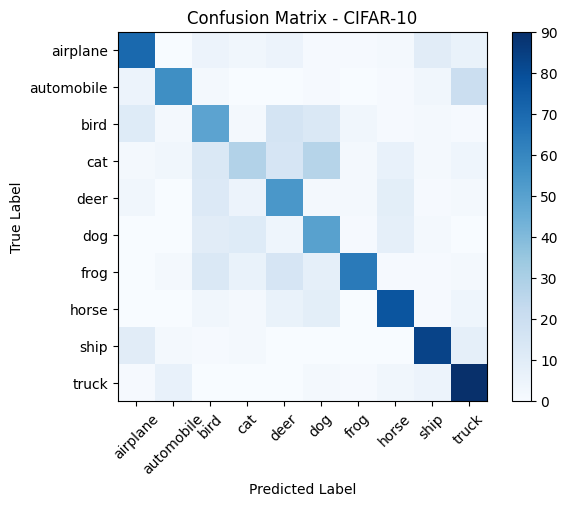

Precision - CIFAR-10: 0.6290186140328071
Recall - CIFAR-10: 0.6198338571250976
F1 score for CIFAR-10: 0.6151060921085931


In [11]:
print_confusion_matrix_and_metrics(cifar10_model, cifar10_x_test, cifar10_y_test, "CIFAR-10", class_names_cifar10)